In [1]:
#todo ensure Fs is right
#todo add the window sampling approach from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8440852/
#todo add normalisation and downsampling to preprocess signals

# Imports

In [1]:
import sns
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

2023-12-11 12:58:43.240621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
import importlib
import data_loading
import data_processing

importlib.reload(data_loading)
importlib.reload(data_processing)

from data_loading import load_dataset, create_input_space, augment_data
from data_processing import preprocess_signals, plot_signal_samples

In [2]:
data = load_dataset()

In [3]:
print(len(data))
print(len(data[0]['signals']['ecg']))

8600
2816


# Preprocessing

In [4]:
data_filtered = preprocess_signals(data, 512, 256)

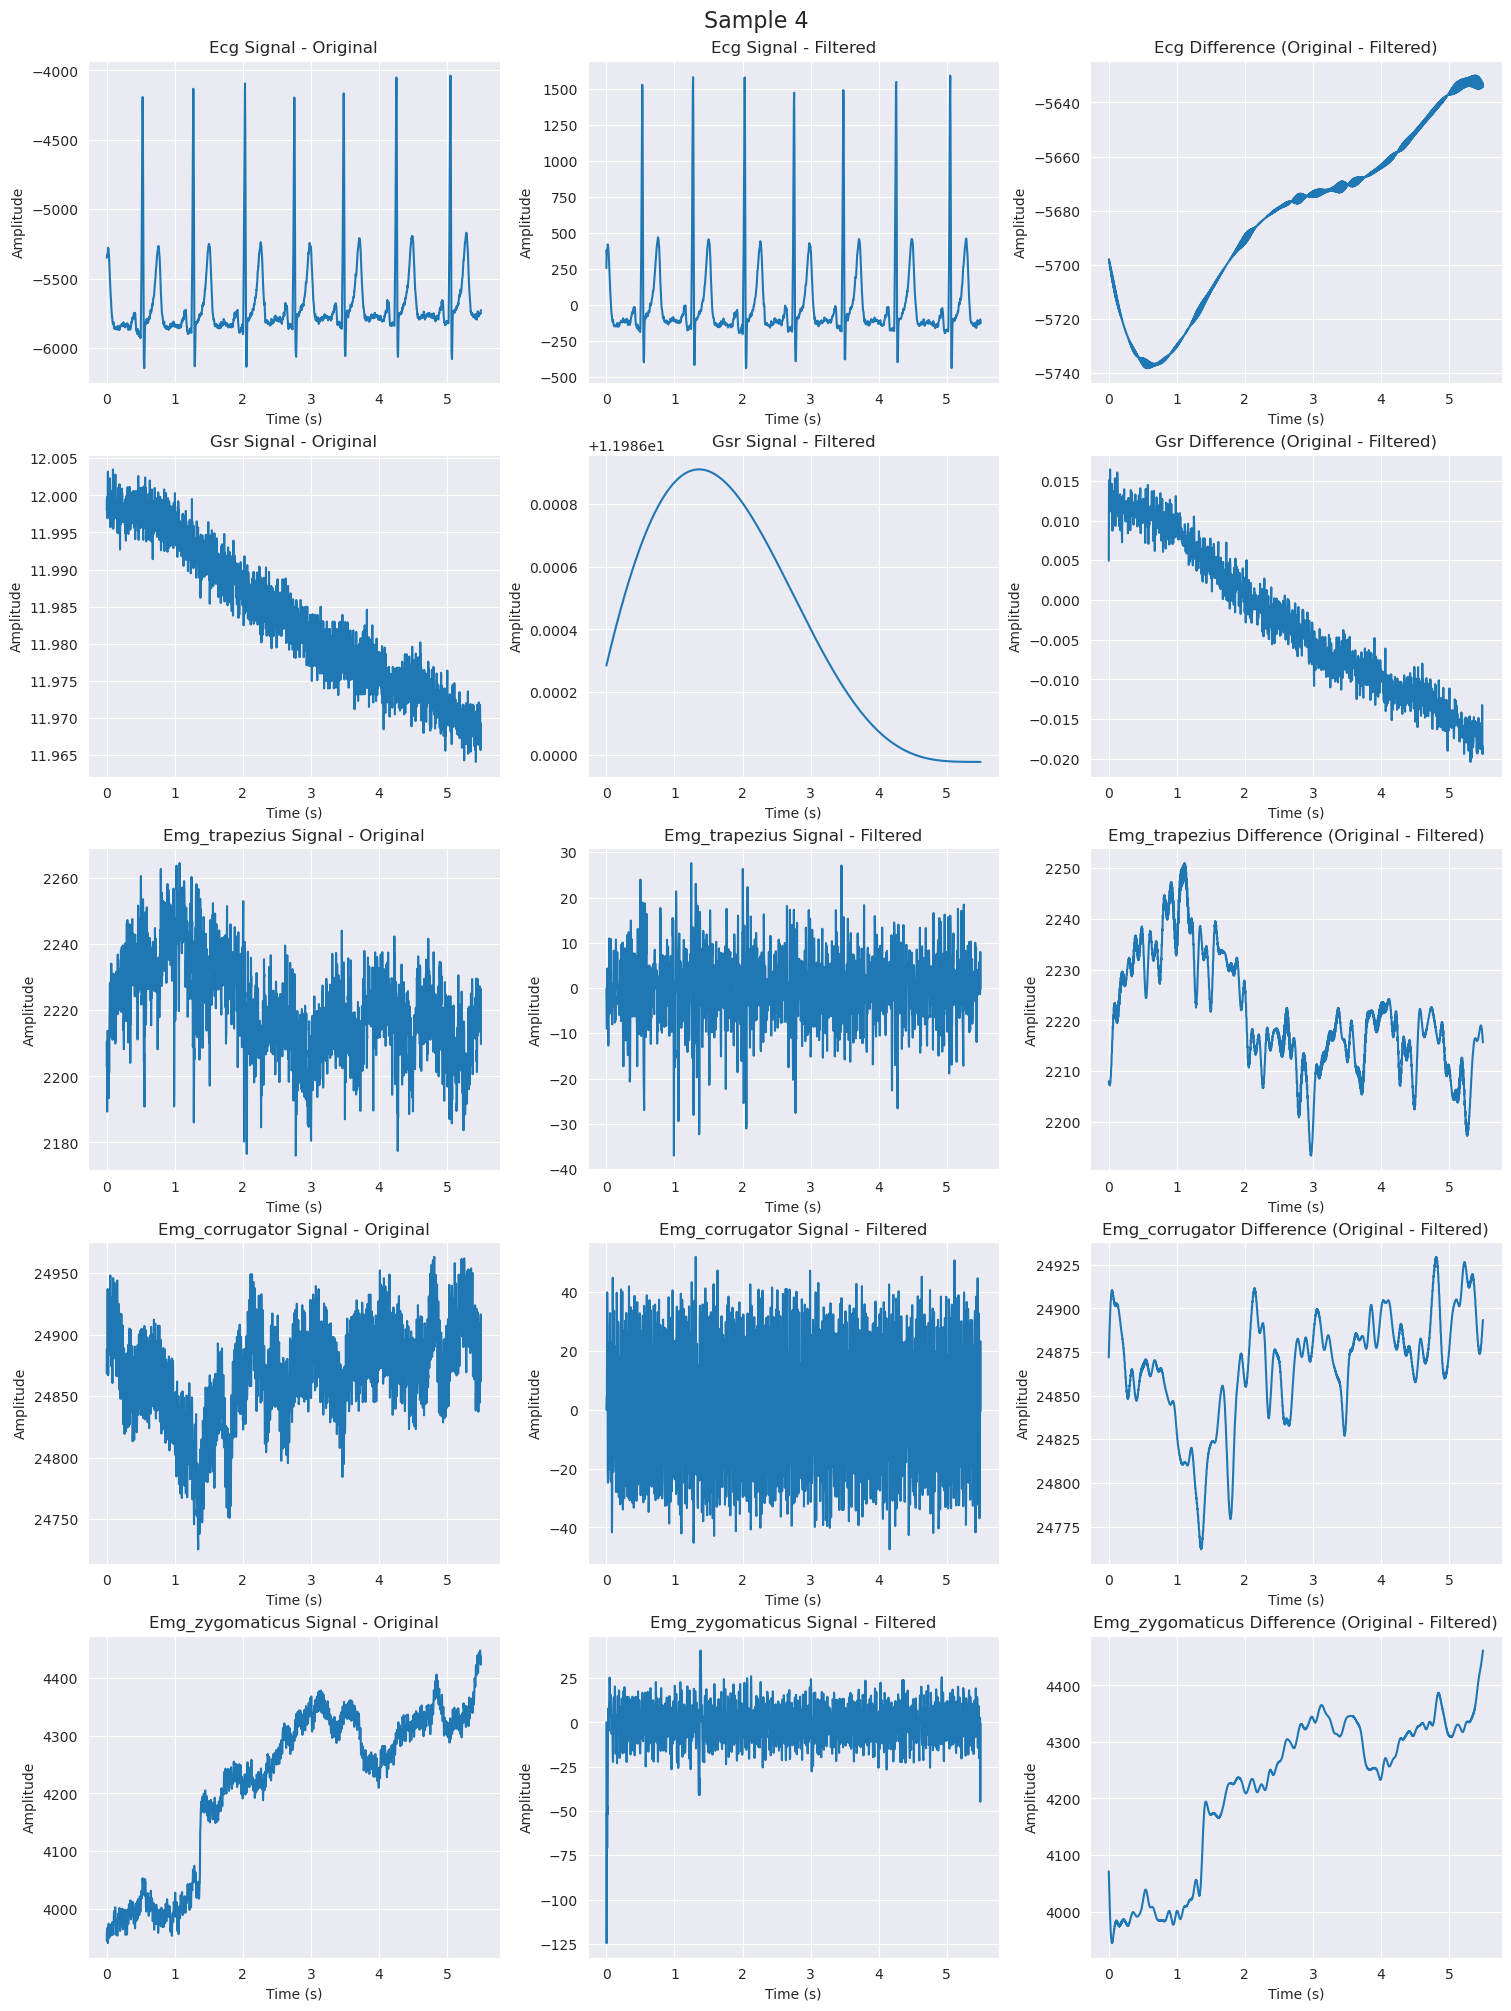

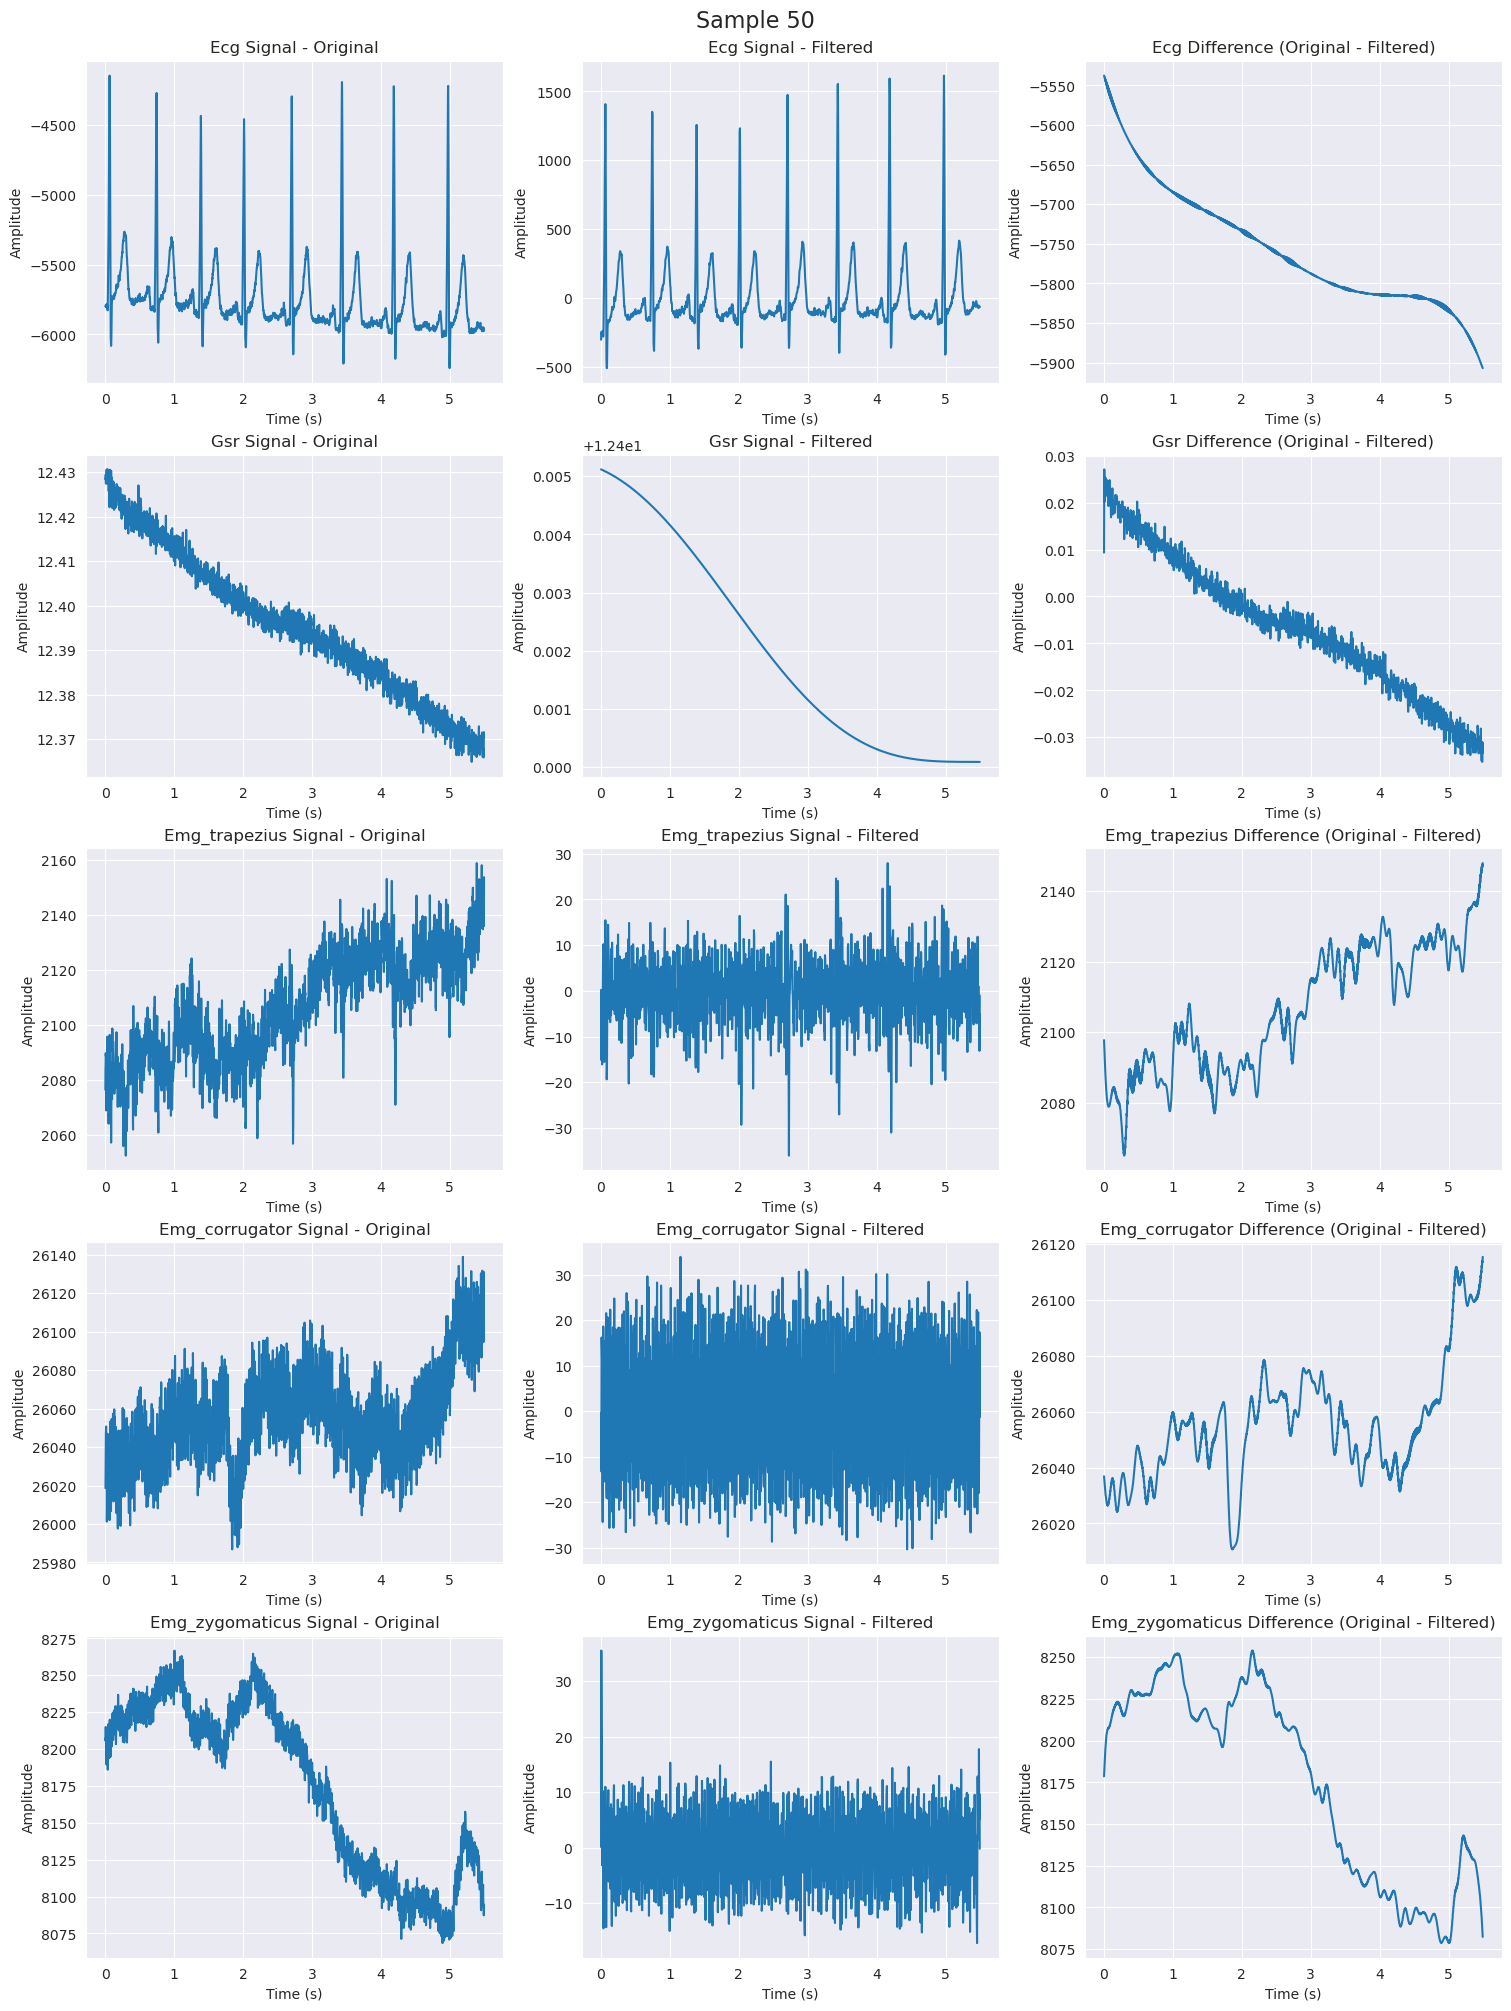

In [5]:
plot_signal_samples(data, data_filtered, [4, 50], 512, 256) 

In [9]:
X, y = create_input_space(data_filtered)

(8600, 1408, 5)
(8600,)


In [12]:
augmented_X, augmented_y = augment_data(X, y)

(77400, 1152, 5)
(77400,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(augmented_X, augmented_y, test_size=0.1, random_state=42)

# Model

In [11]:
X_fft = []

# Assuming F_s (sampling rate) is known
F_s = 512  # Example: replace with actual sampling rate

# Define frequency bounds
f_min = 0
f_max = 100

for sample in X:
    N = len(sample[:, 0])  # Assuming ECG and GSR have the same length

    # Compute the FFT and corresponding frequencies
    ecg_fft = np.abs(np.fft.fft(sample[:, 0]))
    gsr_fft = np.abs(np.fft.fft(sample[:, 1]))
    freqs = np.fft.fftfreq(N, 1/F_s)  # Compute frequencies

    # Select frequencies between f_min and f_max
    indices = np.where((freqs >= f_min) & (freqs <= f_max))

    ecg_fft = ecg_fft[indices]
    gsr_fft = gsr_fft[indices]

    # Append to X_fft
    X_fft.append(np.hstack((ecg_fft, gsr_fft)))

X_fft = np.array(X_fft)

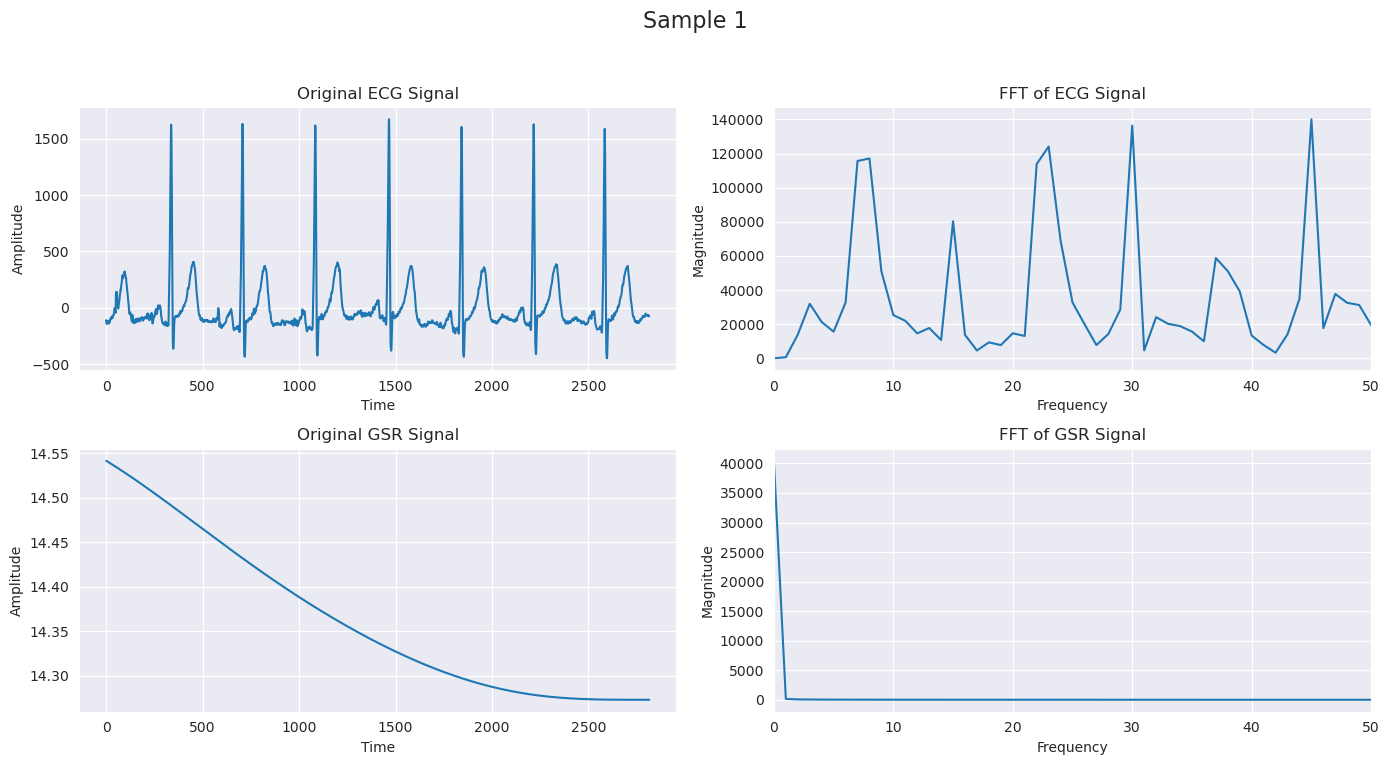

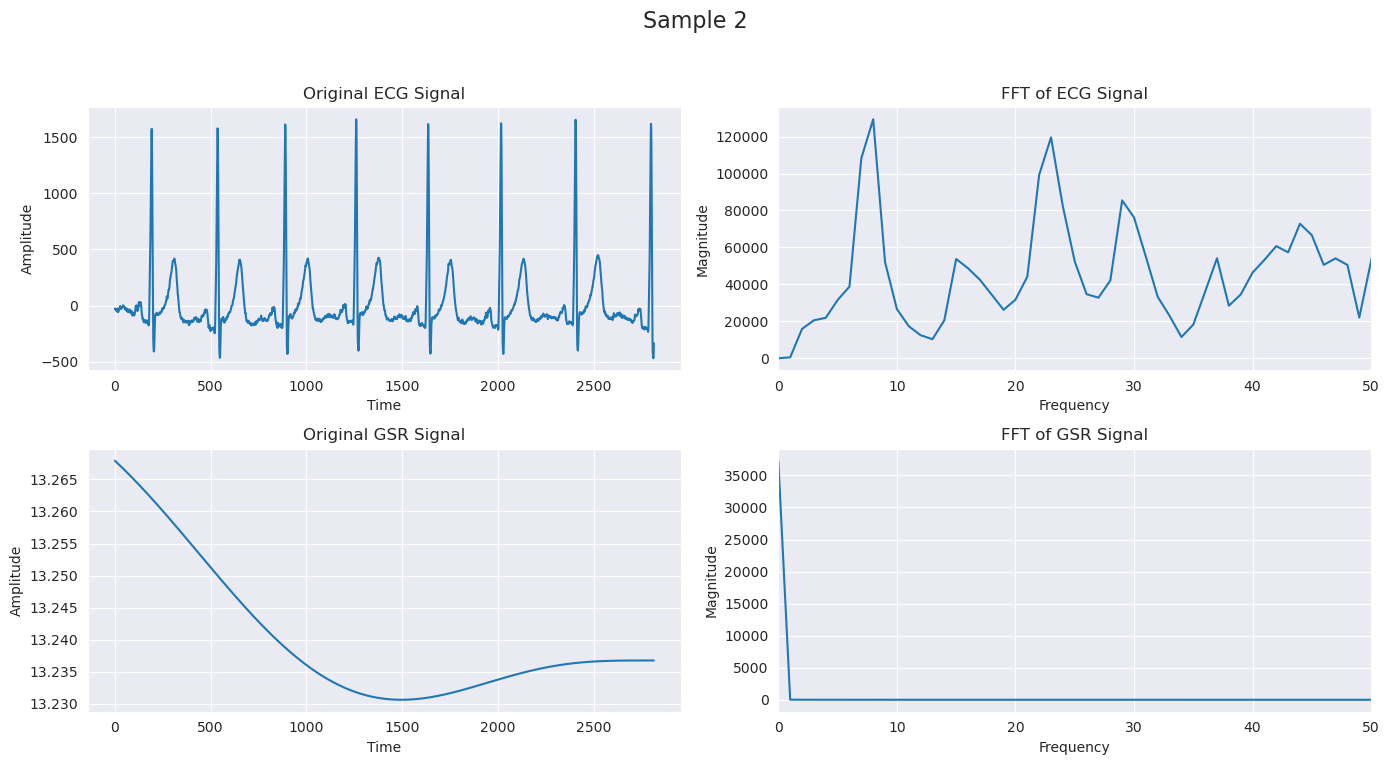

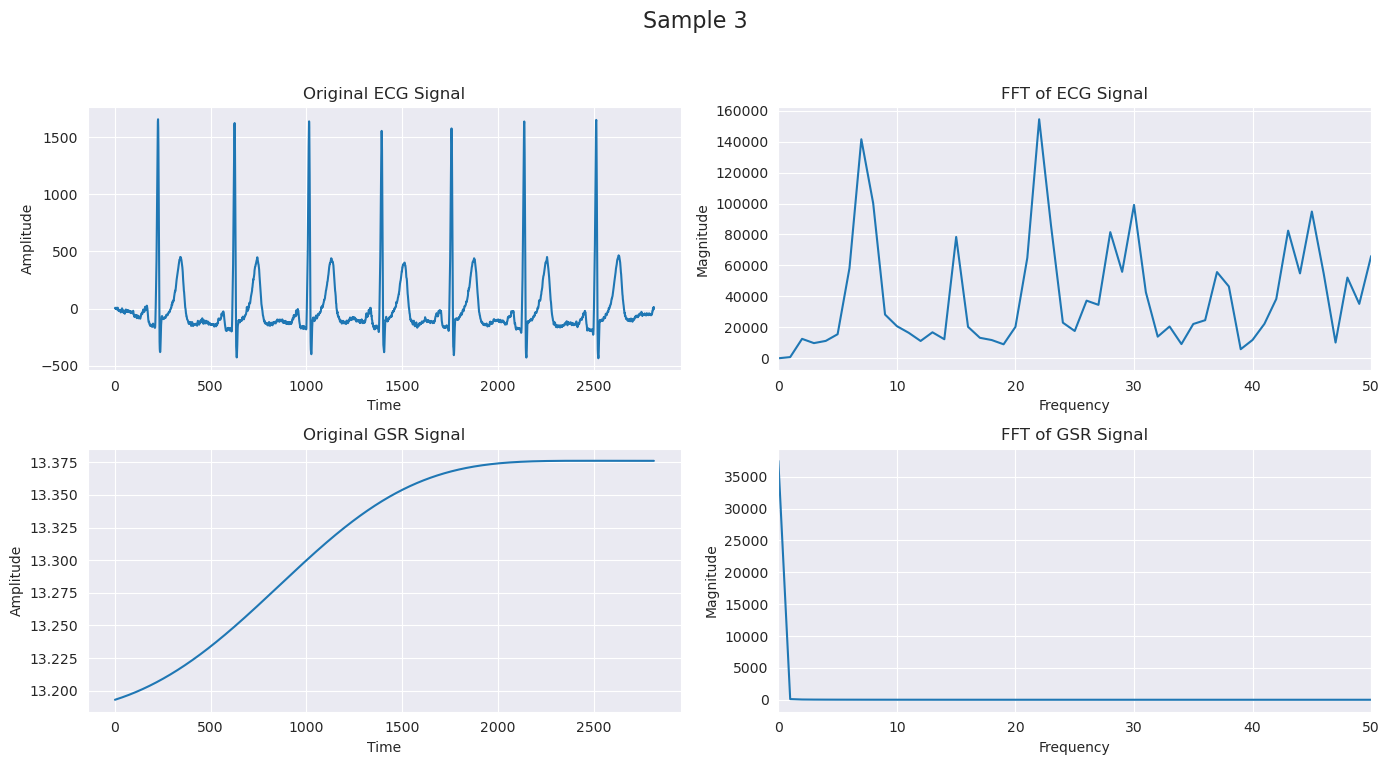

In [13]:
# Select a few samples to plot
num_samples_to_plot = 3

for i in range(num_samples_to_plot):
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'Sample {i+1}', fontsize=16)

    # Original ECG Signal
    axs[0, 0].plot(X[i, :, 0])
    axs[0, 0].set_title('Original ECG Signal')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Amplitude')

    # FFT of ECG Signal
    ecg_fft = np.abs(np.fft.fft(X[i, :, 0]))
    axs[0, 1].plot(ecg_fft)
    axs[0, 1].set_title('FFT of ECG Signal')
    axs[0, 1].set_xlabel('Frequency')
    axs[0, 1].set_ylabel('Magnitude')
    axs[0, 1].set_xlim([0, 50])  # Set x-axis limit

    # Original GSR Signal
    axs[1, 0].plot(X[i, :, 1])
    axs[1, 0].set_title('Original GSR Signal')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Amplitude')

    # FFT of GSR Signal
    gsr_fft = np.abs(np.fft.fft(X[i, :, 1]))
    axs[1, 1].plot(gsr_fft)
    axs[1, 1].set_title('FFT of GSR Signal')
    axs[1, 1].set_xlabel('Frequency')
    axs[1, 1].set_ylabel('Magnitude')
    axs[1, 1].set_xlim([0, 50])  # Set x-axis limit

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [14]:
X_fft_train, X_fft_test, y_train, y_test = train_test_split(X_fft, y, test_size=0.2, random_state=42)

In [15]:
print(X_fft_train.shape)
print(X_fft_test.shape)
print(y_test.shape)
print(y_train.shape)

(6880, 1102)
(1720, 1102)
(1720,)
(6880,)


In [16]:
import numpy as np

# Find indices of NaN values
nan_sample_indices, _ = np.where(np.isnan(X_fft_train))

# Get unique sample indices with NaN values
unique_nan_sample_indices = list(set(nan_sample_indices))

# Create a mask for rows to keep
mask_to_keep = ~np.isin(np.arange(X_fft_train.shape[0]), unique_nan_sample_indices)

# Index X_fft_train and y_train to get versions without NaN-containing rows
X_fft_train_no_nan = X_fft_train[mask_to_keep]
y_train_no_nan = y_train[mask_to_keep]  # Assuming y_train exists and should be indexed similarly

# Check the shapes of the new arrays
print(f'X_fft_train_no_nan shape: {X_fft_train_no_nan.shape}')
print(f'y_train_no_nan shape: {y_train_no_nan.shape}')


X_fft_train_no_nan shape: (6880, 1102)
y_train_no_nan shape: (6880,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the models and parameters to search
models_and_parameters = {
    'MLPClassifier': (MLPClassifier(),
                      {'hidden_layer_sizes': [(50,), (100,), (512, 256, 256, 128, 64)],
                       'activation': ['relu', 'tanh'],
                       'solver': ['adam'],
                       'alpha': [0.0001, 0.001],
                       'max_iter': [200, 400]}),

    'RandomForestClassifier': (RandomForestClassifier(),
                               {'n_estimators': [50, 100, 200],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': [None, 10, 20],
                                'min_samples_split': [2, 5],
                                'min_samples_leaf': [1, 2]})
}

best_models = {}

# Loop over models and parameter grids
for model_name, (model, params) in models_and_parameters.items():
    print(f'Training {model_name}...')
    grid_search = GridSearchCV(model, params, cv=5, verbose=3, n_jobs=-1)

    # Fit models
    grid_search.fit(X_fft_train_no_nan, y_train_no_nan)

    # Store the model
    best_models[model_name] = grid_search.best_estimator_

    # Print the best parameters
    print(f'Best parameters for {model_name}: {grid_search.best_params_}\n')

# `best_models` now contains the best estimator for each model type, trained on your data.


Training MLPClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for MLPClassifier: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (512, 256, 256, 128, 64), 'max_iter': 400, 'solver': 'adam'}

Training RandomForestClassifier...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, \
    confusion_matrix, roc_curve, auc
import seaborn as sns

# Train and evaluate models
for model_name, model in best_models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_fft_train_no_nan, y_train_no_nan)

    # Predict Classes and Probabilities
    y_pred = model.predict(X_fft_test)
    y_prob = model.predict_proba(X_fft_test)

    # Compute Metrics
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve (for multi-class)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()